In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
from os import listdir
import pathlib
from random import randint
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras.utils import load_img,img_to_array
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import MaxPooling2D,Dropout,Dense,Input,Conv2D,Flatten,Conv2DTranspose
from keras.layers import GlobalAveragePooling2D,MaxPool2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

In [3]:
folder = r"C:\Users\ADITYA\Desktop\Dataset"
folder_path = pathlib.Path(folder)

<PIL.Image.Image image mode=RGB size=128x128 at 0x1BCECBEF730>


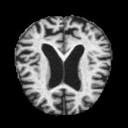

In [4]:
photo = load_img(r"C:\Users\ADITYA\Desktop\Dataset\Moderate_Demented\moderate.jpg")
print(photo)
photo

In [5]:
for file in listdir(folder):
    print(file)

Mild_Demented
Moderate_Demented
Non_Demented
Very_Mild_Demented


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


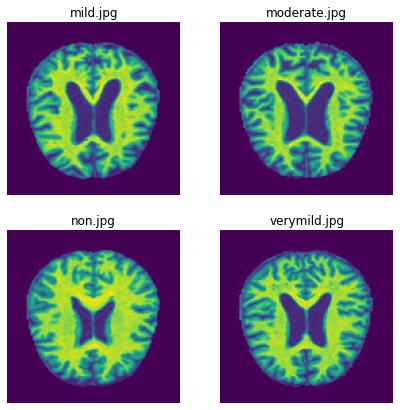

In [6]:
plt.figure(figsize=(7,7),)
j =0
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        if i ==1:
            break;
        img = imread(folder +'/' + file + '/' + image)
        print(type(img))
        ax = plt.subplot(2,2,j+1)
        plt.imshow(img)
        plt.title(image)
        plt.axis('off')
        j = j+1
        i = i +1
plt.show()

In [7]:
file_counts = {} 

for file in os.listdir(folder):
    i = 0
    for image in os.listdir(os.path.join(folder, file)):
        i = i + 1
    file_counts[file] = i

# Print the file counts
for file, count in file_counts.items():
    print(file, count)

Mild_Demented 896
Moderate_Demented 64
Non_Demented 3200
Very_Mild_Demented 2240


In [8]:
IMG_SIZE = 128
DIM = (IMG_SIZE, IMG_SIZE)
ZOOM = [0.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [9]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=BRIGHT_RANGE,
    zoom_range=ZOOM,
    data_format=DATA_FORMAT,
    fill_mode=FILL_MODE,
    horizontal_flip=HORZ_FLIP
)

In [10]:
train_data = train_data_gen.flow_from_directory(
    directory=folder,
    target_size=DIM,
    batch_size=6500,
    shuffle=False
)

Found 6400 images belonging to 4 classes.


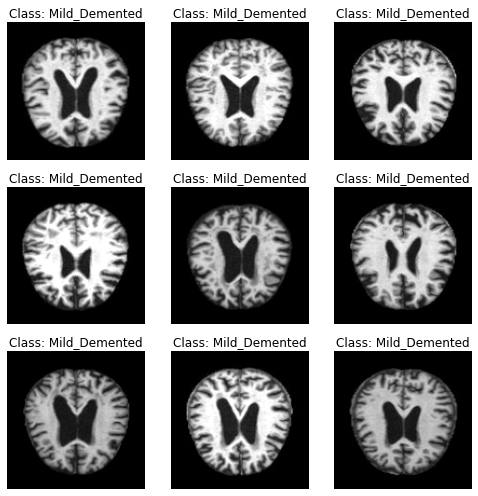

In [11]:
def show_images(generator, y_pred=None):
    # Get image labels
    labels = generator.class_indices
    
    # Get a batch of images and labels
    x, y = generator.next()
    
    # Display a grid of images
    plt.figure(figsize=(7, 7))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = (x[i] * 255).astype(np.uint8)  # Convert image back to 0-255 range
        plt.imshow(image)
        plt.axis("off")
        
        if y_pred is None:
            true_label = list(labels.keys())[np.argmax(y[i])]
            plt.title("Class: {}".format(true_label))
        else:
            true_label = list(labels.keys())[np.argmax(y[i])]
            pred_label = list(labels.keys())[y_pred[i]]
            plt.title("Actual: {}\nPredicted: {}".format(true_label, pred_label))
    
    plt.tight_layout()
    plt.show()

# Display Train Images
show_images(train_data)

In [12]:
train_data_gen = train_data_gen.flow_from_directory(
    directory=folder,
    target_size=DIM,
    batch_size=6500,
    shuffle=False
)

train_data, train_labels = train_data_gen.next()

Found 6400 images belonging to 4 classes.


In [13]:
train_data.shape, train_labels.shape

((6400, 128, 128, 3), (6400, 4))

In [14]:
train_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [15]:
sm = SMOTE(random_state=42)

train_data_reshaped = train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3)
train_data_resampled, train_labels_resampled = sm.fit_resample(train_data_reshaped, train_labels)

print(train_data_resampled.shape, train_labels_resampled.shape)


(12800, 49152) (12800, 4)


In [16]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(6400, 128, 128, 3) (6400, 4)


In [17]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [18]:
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [19]:
def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [20]:
IMAGE_SIZE = [128,128]
act = 'relu'

In [21]:
model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

In [22]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 32, 32, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 16, 16, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 8, 8, 128)         221952    
                                                         

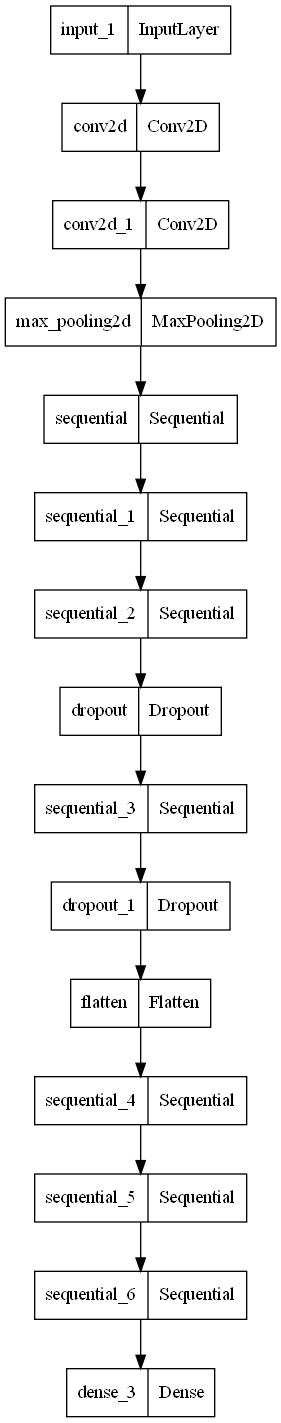

In [23]:
plot_model(model)

In [24]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.01, patience=5, mode='max')
]


In [25]:
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS,callbacks=callbacks)

Epoch 1/50
128/128 [==============================] - 236s 2s/step - loss: 1.7479 - acc: 0.3176 - auc: 0.5678 - f1_score: 0.2371 - val_loss: 2.0236 - val_acc: 0.3457 - val_auc: 0.4430 - val_f1_score: 0.1284
Epoch 2/50
128/128 [==============================] - 197s 2s/step - loss: 1.3219 - acc: 0.4260 - auc: 0.6973 - f1_score: 0.2704 - val_loss: 3.1647 - val_acc: 0.1348 - val_auc: 0.3659 - val_f1_score: 0.0594
Epoch 3/50
128/128 [==============================] - 195s 2s/step - loss: 1.1179 - acc: 0.4885 - auc: 0.7761 - f1_score: 0.3005 - val_loss: 1.8244 - val_acc: 0.3486 - val_auc: 0.6203 - val_f1_score: 0.1316
Epoch 4/50
128/128 [==============================] - 197s 2s/step - loss: 1.0380 - acc: 0.5112 - auc: 0.8024 - f1_score: 0.3095 - val_loss: 2.3823 - val_acc: 0.5107 - val_auc: 0.7770 - val_f1_score: 0.1690
Epoch 5/50
128/128 [==============================] - 196s 2s/step - loss: 1.0030 - acc: 0.5225 - auc: 0.8122 - f1_score: 0.3118 - val_loss: 2.6820 - val_acc: 0.5146 - val_

In [26]:
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

40/40 [==============================] - 7s 170ms/step - loss: 0.9604 - acc: 0.7367 - auc: 0.9116 - f1_score: 0.6653
Testing Accuracy: 73.67%


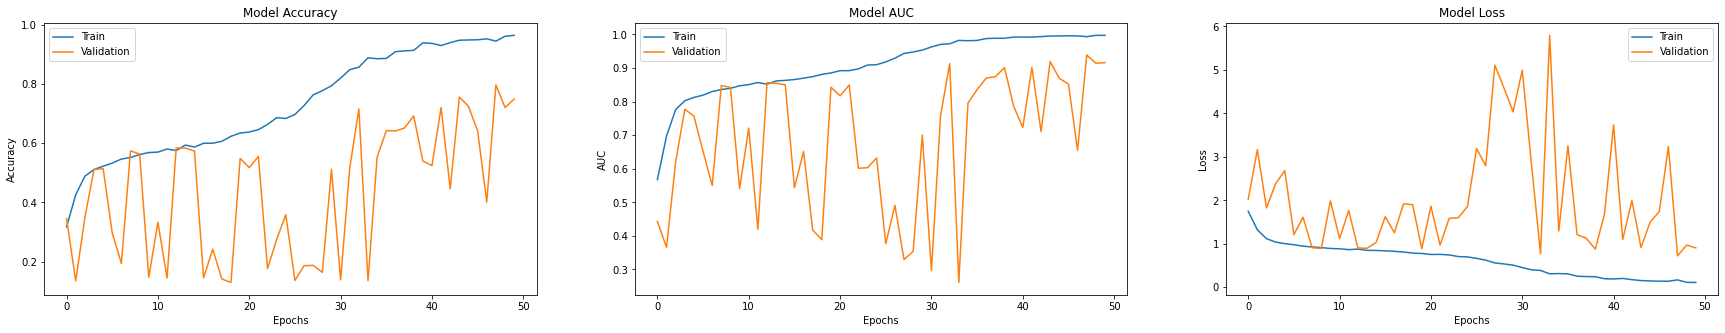

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(30, 5))

metrics = ["acc", "auc", "loss"]
labels = ["Accuracy", "AUC", "Loss"]

for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(labels[i]))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(labels[i])
    ax[i].legend(["Train", "Validation"])

plt.show()

# TRANSFER LEARNING

In [28]:
inception = InceptionV3(input_shape=(128,128,3),include_top=False,weights ='imagenet')

In [29]:
for layer in inception.layers:
    layer.trainable = False

In [30]:
inception_model = Sequential([
        inception,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [31]:
inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 dropout_5 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_101 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dense_4 (Dense)             (None, 512)       

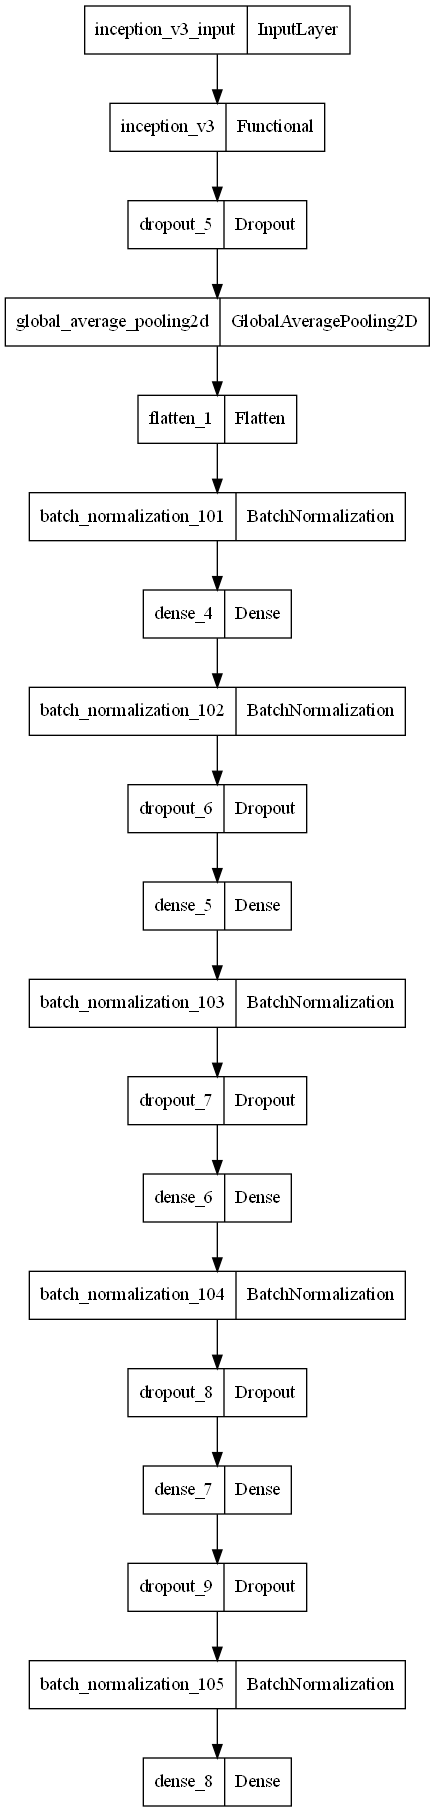

In [32]:
plot_model(inception_model)

In [33]:
INCEPT_CALLBACKS = [
    ModelCheckpoint(filepath='incpt_model_checkpoint.h5', save_best_only=True)
]

In [34]:
incept_history = inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50,callbacks= INCEPT_CALLBACKS)

Epoch 1/50
128/128 [==============================] - 77s 472ms/step - loss: 1.5235 - acc: 0.4494 - auc: 0.7192 - f1_score: 0.3371 - val_loss: 1.0393 - val_acc: 0.5527 - val_auc: 0.8126 - val_f1_score: 0.3065
Epoch 2/50
128/128 [==============================] - 55s 433ms/step - loss: 1.1693 - acc: 0.4832 - auc: 0.7585 - f1_score: 0.3050 - val_loss: 0.9348 - val_acc: 0.5674 - val_auc: 0.8380 - val_f1_score: 0.2957
Epoch 3/50
128/128 [==============================] - 55s 430ms/step - loss: 1.0194 - acc: 0.5322 - auc: 0.8113 - f1_score: 0.3154 - val_loss: 0.8866 - val_acc: 0.5869 - val_auc: 0.8511 - val_f1_score: 0.3193
Epoch 4/50
128/128 [==============================] - 55s 429ms/step - loss: 0.9540 - acc: 0.5520 - auc: 0.8305 - f1_score: 0.3247 - val_loss: 0.8837 - val_acc: 0.5674 - val_auc: 0.8476 - val_f1_score: 0.3040
Epoch 5/50
128/128 [==============================] - 55s 431ms/step - loss: 0.9250 - acc: 0.5745 - auc: 0.8416 - f1_score: 0.3377 - val_loss: 0.8686 - val_acc: 0.5

In [35]:
incept_test_scores = inception_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(incept_test_scores[1] * 100))

40/40 [==============================] - 18s 442ms/step - loss: 0.6850 - acc: 0.7523 - auc: 0.9275 - f1_score: 0.6940
Testing Accuracy: 75.23%


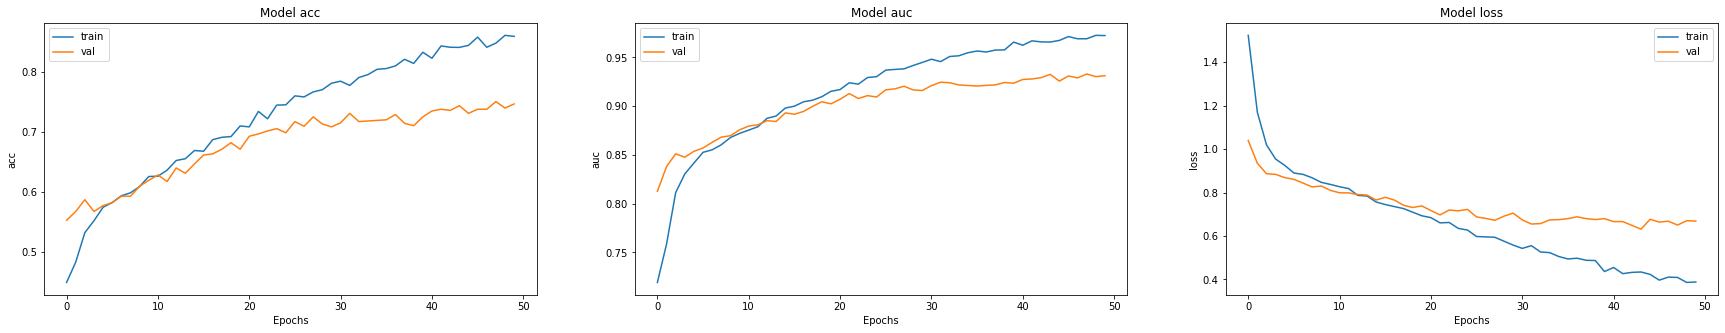

In [36]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(incept_history.history[metric])
    ax[i].plot(incept_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [37]:
model.save("CNN_dataset2.h5")

In [38]:
from tensorflow.keras.models import load_model
import cv2, numpy as np

In [39]:
myModel = load_model('CNN_dataset2.h5')

In [40]:
def reSize(file):
    img = cv2.imread(file)
    img = cv2.resize(img, (128, 128))
    return img

In [41]:
def findMax(lis):
    m = 0
    for i in range(1, len(lis)):
        if lis[i] > lis[m]:
            m = i
    return m

In [44]:
inception_model.save("Transferlearning_dataset2.h5")